# Moisture flux divergence

The idea is to calculate horizontal moisture flux divergence, $\nabla . \vec{\mathrm{mf}}$. This can be used to calculate a moisture flux into a volume by integrating over the volume. I would be able to use this to e.g. calculate moisture flux into an MCS, or an MCS core.

$\vec{\mathrm{mf}} = \rho~q~\vec{v}$       (kg m-3 kg kg-1 m s-1 == kg m-2 s-1)

$\iint_{\mathrm{MCS}}{\nabla . \vec{\mathrm{mf}} ~dA~dz} == \oint_{\mathrm{MCS~boundary}}{\vec{\mathrm{mf}}.\vec{n}} ~dS ~dz$      (kg s-1)

The details get thorny quite quickly, and I still have some unresolved issues with this calc ($dz$).
* \[How to get $\rho$? It does not seem to be available in the standard ERA5 output - perhaps calc. from geopotential height?\] Fixed: use $p = \rho R_d T_v$. I was overthinking it and it is quite straitforward.
* How to get $dz$ taking into account orography?
* My assumptions only hold on a Cartesian grid, can I use them on a lat/lon grid?
* I need to be very careful with ERA5 data: lat decreases with increasing index, ditto z.
* Make sure I am calculating dx/dy on correct grid.
* Check working on Arakawa c-grid calcs to make sure indices all correct.
* Check area/volume weighting.

## Work timeline

* 24-26/10/22: Initial work.
* 9/11/22: Fix rho calc.
* 10/11/22: Flux at the centre then interpolate.
* 10-29/11/22: Sanity checks - scale analysis of total flux in vs max flux, time taken to raise q by 1 g kg-1, rectangular region.
* 10-29/11/22: Within MCS profiles.
* 10-29/11/22: Start work on general tool for doing flux calcs.

In [1]:
import datetime as dt

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage
import xarray as xr

from remake import load_remake

from mcs_prime import PATHS
%matplotlib inline

In [2]:
# Load ERA5 model level data.
e5levels = pd.read_csv('/gws/nopw/j04/mcs_prime/mmuetz/data/ERA5/ERA5_L137_model_levels_table.csv')
e5levels

,n,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3]
0,0,0.000000,0.000000,0.0000,-,-,-,-,-
1,1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018
2,2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042
3,3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063
4,4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090
...,...,...,...,...,...,...,...,...,...
133,133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498
134,134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710
135,135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650
136,136,0.000000,0.997630,1010.8487,1009.5363,30.96,30.96,287.95,1.221341


In [3]:
# Standard density from e5 model level data.
rho_standard = e5levels['Density [kg/m^3]'].values[1:].astype(float)
rho_standard

array([1.800000e-05, 4.200000e-05, 6.300000e-05, 9.000000e-05,
       1.270000e-04, 1.730000e-04, 2.330000e-04, 3.080000e-04,
       4.000000e-04, 5.120000e-04, 6.460000e-04, 8.060000e-04,
       1.007000e-03, 1.251000e-03, 1.546000e-03, 1.913000e-03,
       2.343000e-03, 2.843000e-03, 3.421000e-03, 4.084000e-03,
       4.838000e-03, 5.693000e-03, 6.655000e-03, 7.731000e-03,
       8.931000e-03, 1.026100e-02, 1.172900e-02, 1.333700e-02,
       1.501200e-02, 1.682900e-02, 1.879300e-02, 2.091000e-02,
       2.318600e-02, 2.562400e-02, 2.823200e-02, 3.101300e-02,
       3.397200e-02, 3.711500e-02, 4.044500e-02, 4.396700e-02,
       4.768500e-02, 5.160400e-02, 5.572700e-02, 6.005900e-02,
       6.460200e-02, 6.935900e-02, 7.433000e-02, 7.951600e-02,
       8.491600e-02, 9.045800e-02, 9.611000e-02, 1.019680e-01,
       1.080450e-01, 1.143550e-01, 1.209170e-01, 1.277510e-01,
       1.348770e-01, 1.423210e-01, 1.501060e-01, 1.582480e-01,
       1.667600e-01, 1.756550e-01, 1.849460e-01, 1.9464

In [4]:
from era5_calc import ERA5Calc
e5calc = ERA5Calc('/gws/nopw/j04/mcs_prime/mmuetz/data/ERA5/ERA5_L137_model_levels_table.csv')

In [5]:
# Not sure this is the right way of calculating this.
altitude = e5levels['Geometric Altitude [m]'].values[1:].astype(float)  # in m.
dz = np.concatenate([altitude[:-1] - altitude[1:], altitude[-1:]])
dz

array([5716.74, 2666.12, 2553.02, 2459.24, 2369.1 , 2283.04, 2200.93,
       2122.68, 2048.1 , 1977.06, 1909.41, 1836.85, 1745.42, 1656.96,
       1557.29, 1461.14, 1373.62, 1293.73, 1220.64, 1153.62, 1091.99,
       1035.23,  982.83,  934.37,  889.47,  847.78,  808.7 ,  775.61,
        746.25,  718.62,  692.59,  668.03,  644.83,  622.91,  602.17,
        582.52,  563.89,  546.22,  529.43,  513.48,  498.31,  483.86,
        470.1 ,  456.93,  444.2 ,  431.85,  419.87,  408.24,  396.78,
        386.79,  377.48,  369.27,  362.09,  355.9 ,  350.58,  346.15,
        342.54,  339.53,  336.72,  333.95,  331.18,  328.46,  325.74,
        323.06,  320.39,  317.75,  315.12,  312.53,  309.95,  307.4 ,
        304.86,  302.34,  299.86,  297.38,  294.93,  292.24,  291.47,
        291.58,  291.66,  291.72,  291.77,  291.79,  291.8 ,  291.79,
        291.75,  291.69,  291.63,  291.53,  291.42,  291.29,  291.14,
        290.98,  290.79,  290.59,  290.  ,  288.32,  284.96,  280.1 ,
        274.19,  267

In [6]:
# Load some ERA5 u, v, q data.
year = 2020
month = 1
day = 11
e5datadir = PATHS['era5dir'] / f'data/oper/an_ml/{year}/{month:02d}/{day:02d}'

In [7]:
h = 6

e5time = dt.datetime(year, month, day, h, 0)
e5paths = [e5datadir / (f'ecmwf-era5_oper_an_ml_{t.year}{t.month:02d}{t.day:02d}'
                         f'{t.hour:02d}00.{var}.nc')
            for var in ['u', 'v', 't', 'q', 'lnsp']
            for t in [e5time, e5time + dt.timedelta(hours=1)]]

In [8]:
e5 = (xr.open_mfdataset(e5paths).sel(latitude=slice(60, -60))
      .mean(dim='time').load())

In [9]:
u, v = e5.u.values, e5.v.values
q = e5.q.values
T = e5.t.values
lnsp = e5.lnsp.values

In [10]:
p = e5calc.calc_pressure(lnsp)
Tv = e5calc.calc_Tv(T, q)
rho = e5calc.calc_rho(p, Tv)

In [11]:
q.shape

(137, 481, 1440)

In [12]:
# Check which way roll works!
np.roll(np.arange(10), -1)

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

In [13]:
def calc_mf_u(rho, q, u):
    """Calculates the x-component of density-weighted moisture flux on a c-grid"""
    def calc_mid(var):
        return (var + np.roll(var, -1, axis=2)) / 2
    # return calc_mid(rho) * calc_mid(q) * calc_mid(u)
    return calc_mid(rho * q * u)

def calc_mf_v(rho, q, v):
    """Calculates the y-component of density-weighted moisture flux on a c-grid"""
    def calc_mid(var):
        s1 = (slice(None), slice(None, -1), slice(None))
        s2 = (slice(None), slice(1, None), slice(None))
        return (var[s1] + var[s2]) / 2
    return calc_mid(rho * q * v)


In [14]:
def calc_div_mf(rho, q, u, v, dx, dy):
    """Calculates the divergence of the moisture flux

    Switches back to original grid, but loses latitudinal extremes.
    Keeps longitudinal extremes due to biperiodic domain.
    """
    mf_u = calc_mf_u(rho, q, u)
    mf_v = calc_mf_v(rho, q, v)
    dqu_dx = (mf_u - np.roll(mf_u, 1, axis=2)) / dx[None, :, None]
    # Note, these indices are not the wrong way round!
    # latitude decreases with increasing index, hence I want the opposite
    # to what you would expect.
    dqv_dy = (mf_v[:, :-1, :] - mf_v[:, 1:, :] ) / dy
    print(mf_u.shape)
    print(mf_v.shape)
    
    return dqu_dx[:, 1:-1] + dqv_dy

In [15]:
# Calc dx/dy.
dx_deg = e5.longitude.values[1] - e5.longitude.values[0]
dy_deg = e5.latitude.values[0] - e5.latitude.values[1]  # N.B. want positive so swap indices.
Re = 6371e3  # Radius of Earth in m.

dy = dy_deg / 360 * 2 * np.pi * Re  # km
dx = np.cos(e5.latitude.values * np.pi / 180) * dx_deg / 360 * 2 * np.pi * Re  # km

lats_mids = (e5.latitude.values[:-1] + e5.latitude.values[1:]) / 2
dx_mids = np.cos(e5.latitude.values * np.pi / 180) * dx_deg / 360 * 2 * np.pi * Re  # km

print(dx_deg, dy_deg)
print(dx[0], dx.max(), dx[-1], dy)

0.25 0.25
13899.366 27798.734 13899.366 27798.731661139685


In [16]:
div_mf = calc_div_mf(rho, q, u, v, dx, dy)

(137, 481, 1440)
(137, 480, 1440)


In [17]:
div_mf.shape

(137, 479, 1440)

In [18]:
div_mf[0, 0, 0]

-3.470494637775524e-16

In [19]:
mf_u = calc_mf_u(rho, q, u)

In [20]:
mf_v = calc_mf_v(rho, q, v)

In [21]:
# Check a hand-calc gives the same values as the fancy calc.
# Note, use dx[1] for to match mf_u[0, 1, X], and remember to reverse the order of the v calc.
np.isclose((mf_u[0, 1, 0] - mf_u[0, 1, -1]) / dx[1] + (mf_v[0, 0, 0] - mf_v[0, 1, 0]) / dy, div_mf[0, 0, 0])

True

In [22]:
np.isclose((mf_u[5, 6, 2] - mf_u[5, 6, 1]) / dx[6] + (mf_v[5, 5, 2] - mf_v[5, 6, 2]) / dy, div_mf[5, 5, 2])

True

In [23]:
# Load a mask to try masking out MCSs.
mcs_mask_time = e5time + dt.timedelta(minutes=30)
e5h = load_remake('../../remakefiles/era5_histograms.py')
# e5h
t = e5h.GenERA5Masks.tasks.filter(year=year, month=month, day=day)[0]
e5mask = xr.open_dataset(t.outputs['e5mask'])
cns = np.unique(e5mask.MCS_cloudnumber.values[6])[1:]

In [24]:
e5mask.MCS_cloudnumber.values[6].shape

(481, 1440)

In [25]:
div_mf.shape

(137, 479, 1440)

In [26]:
# Calculate areas of cells.
dx_rad = dx_deg * np.pi / 180
dy_rad = dy_deg * np.pi / 180
lats_rad = (e5.latitude.values * np.pi / 180)[::-1]
Acell = dx_rad * Re**2 * (np.sin(lats_rad + dy_rad / 2) - np.sin(lats_rad - dy_rad / 2))

In [27]:
# Calc. an area weighted and volume weighted div moisture flux.
Aweighted_div_mf = div_mf * Acell[None, 1:-1, None]
Vweighted_div_mf = div_mf * Acell[None, 1:-1, None] * dz[:, None, None]

vert_idx = np.ones(div_mf.shape[0]).astype(bool)

In [28]:
# Use 111 as model level at approx 800 hPa.
ml = 111

In [29]:
# %%timeit
# 4.86 s ± 96.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# This is the full (horizontal) calc.
vals1 = []
for cn in cns:
    # Use array broadcasting to multiply ones (where the current cloudnumber (cn) is true) by 
    # area weighted divergence of moisture flux.
    vals1.append((Vweighted_div_mf[ml:] * (e5mask.MCS_cloudnumber.values[6] == cn)[None, 1:-1, :]).sum())
vals1 = np.array(vals1)

11.6 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
# %%timeit
# 1.17 s ± 188 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# Faster than above, which I was a bit surprised by, due to having to do do the same sorts of calcs
# and also a cast.
vals2 = []
for cn in cns:
    # Use array broadcasting to create mask (where the current cloudnumber (cn) is true) to select vals from 
    # area weighted divergence of moisture flux.
    m = (vert_idx[ml:, None, None] * (e5mask.MCS_cloudnumber.values[6] == cn)[None, 1:-1, :])
    vals2.append(Vweighted_div_mf[ml:][m].sum())
vals2 = np.array(vals2)

-687338044.2410609

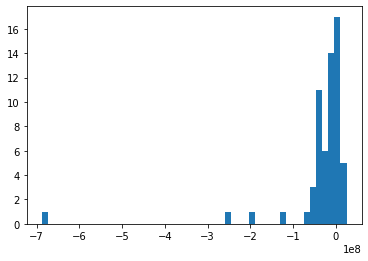

In [34]:
# Make sure `timeit` commented out above or vals not stored.
plt.hist(vals2, bins=50)
vals2.min()

Not sure why all these values are negative! I would have thought there should be substantial moisture flux into the lower levels of an MCS.

EDIT: there is! This is the sum of the divergence, after all. All values of mass gain by the region are therefore positive.

In [35]:
print(vals1[:3], vals2[:3], np.isclose(np.array(vals1), np.array(vals2)).all())
print(np.abs(np.array(vals1) - np.array(vals2)).max())
print(vals2.min())

NameError: name 'vals1' is not defined

## Sanity check

Done for a calc which had a bug in it - used u instead of v.

Max value of moisture flux into a region is 687,296,548 kg s-1 (7 x 10$^8$ kg s-1). Is this reasonable? Lets pull out some standard values of $\rho$, $q$ and $u$ and find out.

Specifically, I take a tropical grid cell (max area), and calc the area of its wall. Then calc the moisture flux (kg s-1) into that cell under the max. u winds and mean (and later max) q, rho. This is unrealistic because the assumption is that there is no flow out of the cell.

TODO: how long to wait before it raises the moisture by 1 g/kg.

In [36]:
print(rho[ml:].mean())
print(q[ml:].mean())
print(u[ml:].max(axis=(1, 2)).mean())

1.1263736449935224
0.008355112
31.813047


In [37]:
print(dx.max())

27798.734


In [38]:
dz[ml:].sum()

1750.63

In [39]:
wall_area_tropical_cell = dx.max() * dz[ml:].sum()  # m2

In [40]:
high_mf = rho[ml:].mean() * q[ml:].mean() * u[ml:].max(axis=(1, 2)).mean()  # kg m-2 s-1

In [41]:
water_gain_rate = wall_area_tropical_cell * high_mf  # kg s-1

In [42]:
water_gain_rate

14569995.230097642

In [43]:
water_gain_rate

14569995.230097642

So, for one tropical grid cell, with standard values of density and specific humidity, and the highest values of horizontal winds, you can get:

14,569,995 kg s-1

Means that approx. 40 cells with this much flux in would be needed. Not entirely unreasonable but quite high.

In [44]:
super_high_mf = rho[ml:].max(axis=(1, 2)).mean() * q[ml:].max(axis=(1, 2)).mean() * u[ml:].max(axis=(1, 2)).mean()  # kg m-2 s-1

In [45]:
super_high_water_gain_rate = wall_area_tropical_cell * super_high_mf  # kg s-1
super_high_water_gain_rate

42429964.12487476

So, for one tropical grid cell, with highest values of density, specific humidity, and horizontal winds, you can get:

42,429,964 kg s-1

Means that approx. 15 cells with this much flux in would be needed. Orders of magnitude seem plausible, and this is a very high upper bound on what you might expect.

In [46]:
np.argmin(vals2)  # max. val comes from idx 8.

0

In [49]:
cns[0]  # ... which is cn 1.

1

In [51]:
(e5mask.MCS_cloudnumber.values[6] == cns[0]).sum()  # cn1 comprises 2915 grid cells (wow!)

2915

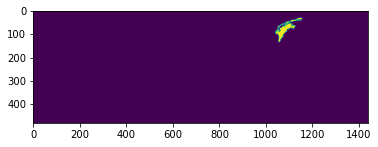

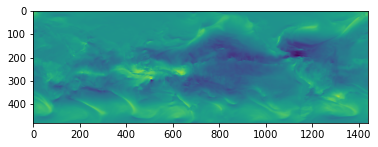

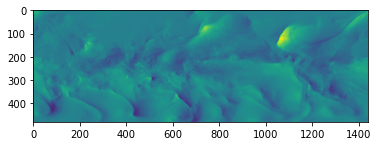

In [53]:
plt.imshow(e5mask.MCS_cloudnumber.values[6] == cns[0])
# plt.xlim((550, 650))
# plt.ylim((250, 350))

plt.figure()
plt.imshow(mf_u[ml:].mean(axis=0))
#plt.xlim((550, 650))
#plt.ylim((250, 350))

plt.figure()
plt.imshow(mf_v[ml:].mean(axis=0))
#plt.xlim((550, 650))
#plt.ylim((250, 350))


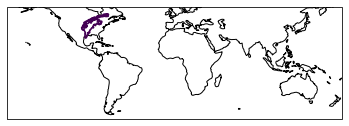

In [54]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.contour(e5mask.longitude, e5mask.latitude, e5mask.MCS_cloudnumber.values[6] == cns[0], levels=[0.5])
ax.coastlines()

In [55]:
e5mask.MCS_cloudnumber.shape

(24, 481, 1440)

In [60]:
# Area of large MCS in m2:
area_mcs = (Acell[:, None] * np.ones((1440, )))[e5mask.MCS_cloudnumber.values[6] == cns[0]].sum()
area_mcs

1686296545728.0

In [61]:
# Increase in column water vapour
dTCWV_dt = np.abs(vals2.min()) / area_mcs  # kg m-2 s-1
dTCWV_dt

0.0004076021183713725

In [62]:
# Approx. 1 g m-2 s-1. Say this is distributed over the lowest 10 km == 10,000 m:
rho_avg = 1  # kg m-3
# [s-1]   [kg m-2 s-1]    [m]     [kg m-3]
dq_dt  =  dTCWV_dt     / (10000 * rho_avg)
dq_dt  # [kg kg-1 s-1]

4.0760211837137253e-08

In [64]:
delta_q = 1e-3  # 1 g kg-1
delta_t = delta_q / dq_dt
delta_t / 3600  # 7 hours.

6.814924782228197

So it would take ~7 h to increase the tropospheric moisture by 1 g kg-1. This seems reasonable.

# Sanity checks on simple rectangular area

In [65]:
dummy_mask = np.zeros_like(e5mask.MCS_cloudnumber.values[6]).astype(bool)

In [66]:
dummy_mask.shape

(481, 1440)

In [67]:
dummy_mask[230:250, 700:740] = True

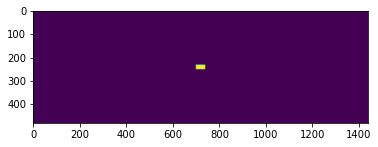

In [68]:
plt.imshow(dummy_mask)

In [69]:
# Use array broadcasting to create mask (where the current cloudnumber (cn) is true) to select vals from 
# area weighted divergence of moisture flux.
m = (vert_idx[ml:, None, None] * dummy_mask[None, 1:-1, :]).astype(bool)
mf_out_of_dummy_area = Vweighted_div_mf[ml:][m].sum()
mf_out_of_dummy_area

56237400.702710986

In [70]:
mf_u_on_grid = rho * q * u
mf_v_on_grid = rho * q * v
w1 = mf_u_on_grid[ml:, 230:250, 700].mean()
w2 = mf_u_on_grid[ml:, 230:250, 740].mean()
w3 = mf_v_on_grid[ml:, 230, 700:740].mean()
w4 = mf_v_on_grid[ml:, 250, 700:740].mean()

mf_approx = - w1 * dy * 20 * dz[ml:].sum() + w2 * dy * 20 * dz[ml:].sum() + w3 * dx[230] * 40 * dz[ml:].sum() - w4 * dx[250] * 40 * dz[ml:].sum()
mf_approx

64417198.78795329

In [71]:
mf1 = mf_u_on_grid[ml:, 230:250, 700]
mf2 = mf_u_on_grid[ml:, 230:250, 740]
mf3 = mf_v_on_grid[ml:, 230, 700:740]
mf4 = mf_v_on_grid[ml:, 250, 700:740]

In [72]:
mf1.shape

(26, 20)

In [73]:
dz[ml:].shape

(26,)

In [74]:
mf_approx2 = (
    -(mf1 * (dy * np.ones(20))[None, :] * dz[ml:][:, None]).sum()
    +(mf2 * (dy * np.ones(20))[None, :] * dz[ml:][:, None]).sum()
    +(mf3 * (dx[230] * np.ones(40))[None, :] * dz[ml:][:, None]).sum()
    -(mf4 * (dx[250] * np.ones(40))[None, :] * dz[ml:][:, None]).sum()
)

In [75]:
mf_approx2

53946984.02445263

In [79]:
print(f'% error: {(mf_out_of_dummy_area - mf_approx2) / mf_out_of_dummy_area * 100:.1f}')

% error: 4.1


# Calculate some within MCS profiles

In [80]:
q_mcs = q[:, 1:-1][(vert_idx[:, None, None] * dummy_mask[None, 1:-1, :]).astype(bool)].reshape(137, -1)

In [81]:
q_mcs.mean(axis=1)

array([2.0818970e-06, 3.0167516e-06, 3.5438582e-06, 4.0605664e-06,
       4.0605664e-06, 4.0605664e-06, 4.0605664e-06, 4.0605664e-06,
       4.0605664e-06, 4.0605664e-06, 4.0605664e-06, 4.0605664e-06,
       4.0605664e-06, 3.9553911e-06, 3.7169084e-06, 3.3853541e-06,
       3.3727847e-06, 3.3147326e-06, 3.0286610e-06, 3.0286610e-06,
       3.0286610e-06, 3.0286610e-06, 3.0286610e-06, 3.0286610e-06,
       3.0282279e-06, 2.7095025e-06, 2.6850030e-06, 2.6850030e-06,
       2.6850030e-06, 2.6850030e-06, 2.6850030e-06, 2.6850030e-06,
       2.6850030e-06, 2.6850030e-06, 2.6850030e-06, 2.6850030e-06,
       2.6850030e-06, 2.6850030e-06, 2.6850030e-06, 2.6850030e-06,
       2.6884115e-06, 2.8180307e-06, 2.9799551e-06, 3.0241138e-06,
       3.0286610e-06, 3.0286610e-06, 3.0286610e-06, 3.0286610e-06,
       3.0286610e-06, 3.0025130e-06, 2.7319277e-06, 2.6850030e-06,
       2.4106807e-06, 2.1833671e-06, 1.7679710e-06, 1.3065163e-06,
       9.4666729e-07, 8.6475802e-07, 8.3292309e-07, 9.8523969e

(0.0, 12000.0)

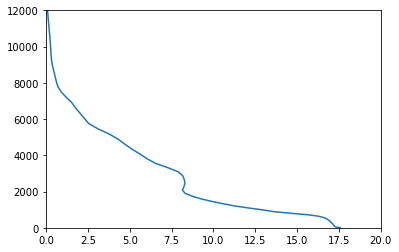

In [82]:
plt.plot(q_mcs.mean(axis=1) * 1e3, altitude)
plt.xlim((0, 20))
plt.ylim((0, 12000))

In [84]:
rho_mcs = rho[:, 1:-1][(vert_idx[:, None, None] * dummy_mask[None, 1:-1, :]).astype(bool)].reshape(137, -1)

In [85]:
rho_mcs.shape

(137, 800)

(0.0, 12000.0)

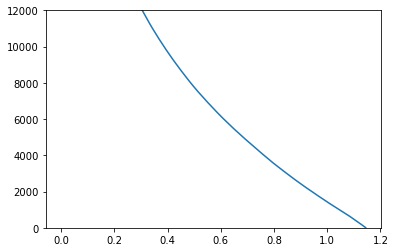

In [86]:
plt.plot(rho_mcs.mean(axis=1), altitude)
# plt.xlim((0, 20))
plt.ylim((0, 12000))

In [87]:
rho[-1].mean()

1.1934438547698818

# Develop code for calculating the arbitrary fluxes into a region.

This is how I would like to do things eventually, so that it could be used by other people for data other than ERA5. However, writing fully general code is quite tricky in this case and would need to be well tested.

In [88]:
class CGrid:
    @staticmethod
    def cell_centre_to_boundary_periodic(field, axis):
        return (np.roll(field, -1, axis=axis) + field) / 2

    @staticmethod
    def cell_centre_to_boundary_nonperiodic(field, axis):
        s1 = [slice(None)] * field.ndim
        s2 = [slice(None)] * field.ndim
        s1[axis] = slice(None, -1)
        s2[axis] = slice(1, None)
        return (field[tuple(s1)] + field[tuple(s2)]) / 2

    def __init__(self, field, gridtype, xaxis=2, yaxis=1, periodic_x=False, periodic_y=False, requires_regrid=True):
        assert xaxis != yaxis, 'xaxis and yaxis must be different'
        assert (xaxis < field.ndim and yaxis < field.ndim), 'xaxis and yaxis must be less than field.ndim'
        assert gridtype in ['centre', 'x', 'y'], f'Invalid gridtype {gridtype}'
        
        self._raw_field = field
        self.gridtype = gridtype
        self.xaxis = xaxis
        self.yaxis = yaxis
        self.periodic_x = periodic_x
        self.periodic_y = periodic_y
        if requires_regrid:
            if self.gridtype == 'x':
                if periodic_x:
                    shift_grid = CGrid.cell_centre_to_boundary_periodic
                else:
                    shift_grid = CGrid.cell_centre_to_boundary_nonperiodic                
                self.field = shift_grid(field, xaxis)
            elif self.gridtype == 'y':
                if periodic_y:
                    shift_grid = CGrid.cell_centre_to_boundary_periodic
                else:
                    shift_grid = CGrid.cell_centre_to_boundary_nonperiodic                
                self.field = shift_grid(field, yaxis)
        else:
            self.field = field
    

class FluxCalculator:
    @staticmethod
    def _deriv_periodic(field, axis, dx):
        return (field - np.roll(field, 1, axis=axis)) / dx
    
    @staticmethod
    def _deriv_nonperiodic(field, axis, dx):          
        s1 = [slice(None)] * field.ndim
        s2 = [slice(None)] * field.ndim
        s1[axis] = slice(None, -1)
        s2[axis] = slice(1, None)
        return (field[tuple(s2)] - field[tuple(s1)]) / dx

    @staticmethod
    def _convert_dx(dx):
        if isinstance(dx, np.ndarray) and dx.ndim == 1:
            broadcast_slice = [None] * field.ndim
            broadcast_slice[axis] = slice(None)
            dx = dx[tuple(broadcast_slice)]
        return dx

    def __init__(self, features, feature_indices, flux_x, flux_y, dx, dy):
        assert flux_x.gridtype == 'x'
        assert flux_y.gridtype == 'y'
        assert flux_x.xaxis == flux_y.xaxis
        assert flux_x.yaxis == flux_y.yaxis
        
        self.feature_mask = features > 0
        self.features = features
        self.feature_indices = feature_indices
        self.xaxis = flux_x.xaxis
        self.yaxis = flux_x.yaxis        
        self.flux_x = flux_x
        self.flux_y = flux_y
        self.dx = FluxCalculator._convert_dx(dx)
        self.dy = FluxCalculator._convert_dx(dy)

    def calc_div(self):
        if self.flux_x.period_x:
            dflux_dx = self._deriv_periodic(self.flux_x.field, self.flux_x.xaxis)
        else:
            dflux_dx = self._deriv_nonperiodic(self.flux_x.field, self.flux_x.xaxis)
        if self.flux_y.period_y:
            dflux_dy = self._deriv_periodic(self.flux_y.field, self.flux_y.yaxis)
        else:
            dflux_dy = self._deriv_nonperiodic(self.flux_y.field, self.flux_y.yaxis)

        if self.flux_x.period_x == self.flux_x.period_y:
            return dflux_dx + dflux_dy        
        elif self.flux_x.period_x and not self.flux_x.period_y:
            xslice = [slice(None)] * self.flux_x.field.ndim
            xslice[self.flux_x.yaxis] = slice(1, -1)
            return dflux_dx[tuple(xslice)] + dflux_dy        
        elif not self.flux_x.period_x and self.flux_x.period_y:
            yslice = [slice(None)] * self.flux_x.field.ndim
            yslice[self.flux_x.yaxis] = slice(1, -1)
            return dflux_dx + dflux_dy[tuple(yslice)]        

    def calc_boundary(self):
        return (
            1 * (self.feature_mask & ~np.roll(self.feature_mask, -1, axis=0)) + 
            2 * (self.feature_mask & ~np.roll(self.feature_mask, -1, axis=1)) + 
            4 * (self.feature_mask & ~np.roll(self.feature_mask, 1, axis=0)) + 
            8 * (self.feature_mask & ~np.roll(self.feature_mask, 1, axis=1))
        ).astype('int8')
        
    def integrate_div(self):
        div_flux = self.calc_div()
        Acell = dx_rad * Re**2 * (np.sin(lats_rad + dy_rad / 2) - np.sin(lats_rad - dy_rad / 2))
        # dz = ??
        return np.array([div_flux[self.feature_label == i].sum() * Acell[None, 1:-1, None] * dz[:, None, None]
                         for i in self.feature_indices])
    
    def integrate_boundaries(self):
        bmask = self.calc_boundary()
        
        flux_outx = ((bmask & 2).astype(bool) * self.flux_x.field - (bmask & 8).astype(bool) * np.roll(self.flux_x.field, 1, axis=1)) * self.dy_mids
        flux_outy = ((bmask & 1).astype(bool) * self.flux_y.field * self.dx_mids[None, :-1, None] - 
                     (bmask & 4).astype(bool) * np.roll(self.flux_y.field, 1, axis=0) * self.dx_mids[:, 1:, None])
        flux_out = flux_outx + flux_outy
        return np.array([flux_out[self.feature_label == i].sum() for i in self.feature_indices])

In [89]:
mf_x = CGrid(rho * q * u, 'x', periodic_x=True)

In [90]:
(mf_u == mf_x.field).all()

True

In [91]:
mf_y = CGrid(rho * q * v, 'y', periodic_x=True)

In [92]:
(mf_v == mf_y.field).all()

True

In [93]:
e5.latitude.values[[0, -1]]

array([ 60., -60.], dtype=float32)